In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize,RegexpTokenizer
import string
import nltk
from nltk.corpus import stopwords
import en_core_web_sm
import gensim
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import operator
from matplotlib import pyplot as plt
#from pyspark.sql.functions import split,col,udf,lit

Read the Reviews dataset

In [2]:
rev=pd.read_csv('yelp/yelp_review.csv',encoding='UTF-8')

Filter based on the uer id CxDOIDnH8gp9KXzpBHJYXw

In [3]:
filt_condition='user_id'
filt_variable='CxDOIDnH8gp9KXzpBHJYXw'

In [4]:
rev1=rev[rev[filt_condition]==filt_variable]

Tokenize the reviews and remove stopwords

In [5]:
rev1['tokenized_text'] = rev1['text'].apply(lambda x:x.lower()).apply(word_tokenize) 

/home/vishwa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
punctuation = list(string.punctuation)
stopWords = set(stopwords.words('english'))

In [7]:
docs=list(rev1['tokenized_text'])

In [8]:
filtered_docs=[]
for i in docs:
    filt = []
    for w in i:
        if w.lower()not in stopWords and w not in punctuation:
            filt.append(w)
    filtered_docs.append(filt)

Perform Stemming


In [9]:


nlp = en_core_web_sm.load()

In [10]:
final_txt=[[t.lemma_ for t in nlp(' '.join(i))] for i in filtered_docs]

Run gensim wor2vec model


In [11]:
model = gensim.models.Word2Vec(final_txt,size=150,window=10,min_count=10,workers=10,iter=10)

In [12]:
corpus = model.wv.index2word

In [13]:
cv=CountVectorizer()
word_count_vector=cv.fit_transform([ ' '.join(i) for i in final_txt ])

Get the tfidf documnet word matrix

In [14]:
vect = TfidfVectorizer()
tfidf_matrix = vect.fit_transform([ ' '.join(i) for i in final_txt ])
df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names())

/home/vishwa/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [15]:
freq = np.ravel(tfidf_matrix.sum(axis=0))

In [16]:

vocab = [v[0] for v in sorted(vect.vocabulary_.items(), key=operator.itemgetter(1))]
fdist = dict(zip(vocab, freq)) 

Pick the top 50 words based on the TF-iDF value

In [19]:
topwords=[i[0] for i in sorted(fdist.items(),key=operator.itemgetter(1),reverse=True) if i[0] in model.wv.index2word][:50]

Construct the Dendogram


In [20]:
corpus = topwords 
word_vector = []
for i in corpus:
    word_vector.append(model[i]) # Gets the word_vectors of each word
    word_vector1 = np.array(word_vector)#converting it into Numpy array
HC = linkage(word_vector, 'ward')

/home/vishwa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


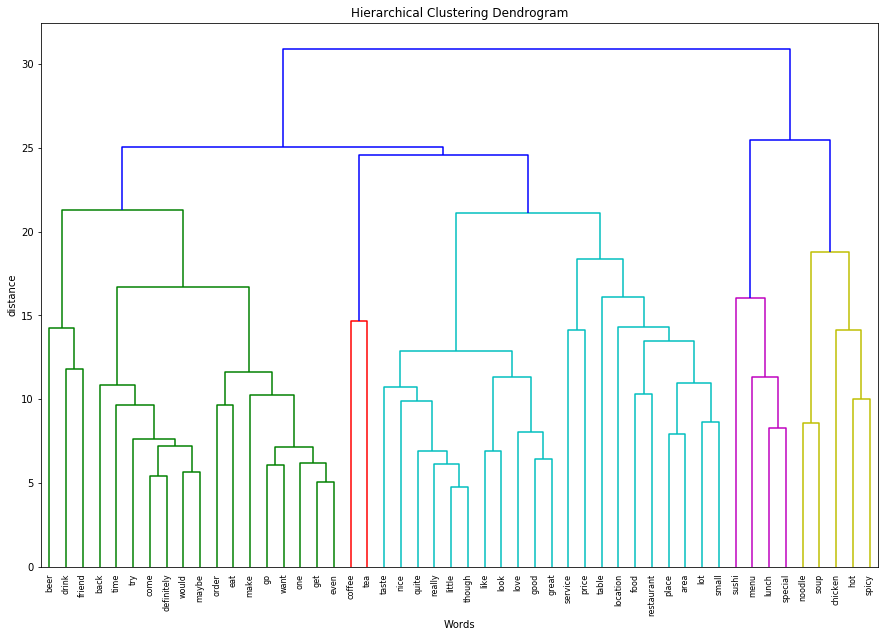

In [22]:
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('distance')
dendrogram(
    HC,labels=topwords,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

From the clusters formed from this Dendrogram we can infer this user prefers to have Sushi for lunch and likes to have it along with hot